<a href="https://colab.research.google.com/github/nicolasrondan/cv-um-2021/blob/main/practico-4/Practico_4_Reconocimiento_de_Objetos_Solucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/practico-4/

/content/drive/MyDrive/computer-vision-um/cv-um-2021/practico-4


# INSTALACION (SOLO EJECUTAR EN GOOGLE COLAB) 
***Importante*** *: El codigo de instalción hace que el entorno se reinicie, luego de reiniciar volver a todas las celdas (Incluso montar Google driver) para que los paquetes necesarios queden instalado correctamente.*

In [3]:
#@title Installing condacolab (ONLY GOOGLE COLAB)
!pip install -q condacolab

In [4]:
#@title install conda
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [5]:
#@title check conda
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [6]:
#@title install cyvlfeat
!conda install -c conda-forge cyvlfeat -y

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cyvlfeat


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.1               |   py37h89c1867_0         3.1 MB  conda-forge
    cyvlfeat-0.7.0             |   py37h27c44b0_0         1.3 MB  conda-forge
    libblas-3.9.0              |       9_openblas          11 KB  conda-forge
    libcblas-3.9.0             |       9_openblas          11 KB  conda-forge
    libgfortran-ng-9.3.0       |      hff62375_19          22 KB  conda-forge
    libgfortran5-9.3.0         |      hff62375_19         2.0 MB  conda-forge
    liblapack-3.9.0            |       9_openblas          11 KB  conda-forge
    libopenblas-0.3.15         |pthreads_h8fe5266_1         9.2 MB  conda-forge
    numpy-1.2

# Introducción

En este practico vamos a trabajar sobre los distintos algoritmos de reconocimiento de objetos y escenas vistos en clase. En particular vamos a clasificar imágenes de distintos tipos de escenas (Cocina, Dormitorio, Oficina, etc). Para ello vamos a utilizar dos representaciones de imágenes diferentes (Imágenes raw y Bag of Words basado en descriptores SIFT). A su vez se van a utilizar dos clasificadores KNN y SVM para clasificar las imágenes. Se  van a clasificar las 15 categorias de imágenes del articulo [Lazebnik et al 2006](https://inc.ucsd.edu/~marni/Igert/Lazebnik_06.pdf) y se va a implementar uno de los baselines utilizados en el articulo para clasificar imágenes (SIFT + BoW).

Los datos de entrenamineto de este practico se encuentran en el siguiente en enlace de [Sharepoint](https://umontevideo.sharepoint.com/:u:/r/sites/ComputerVision/Shared%20Documents/Practico%203/Practico3.zip?csf=1&e=CMbD5n). Descargar el archivo descompromirlo y copiar la carpeta en el su drive:

\* `/content/drive/MyDrive/computer-vision-um/cv-um-2021/practico-4/data`


\**Este practico fue adaptado de un trabajo propuesto en el curso Image and Vision Computing de University of Edinburgh y originalmente diseñando por James Hays para Brown University.*

## Configuración
Para la implementación de BoW y SIFT en la Parte 2 de este laboratorio vamos a utilizar el paquete vlfeat para Pyhton (www.vlfeat.org). Para instalarlo en google colab es necesario ejectutar el bloque de instalación en el encabezado del notebook. Si quieren instalarlo localmente en su computadora es recomendable usa conda un con un *virtualenv*. Para instalar vlfeat utilizar el siguiente comando dentro de su *virtualenv*.



```
conda install -c conda-forge cyvlfeat
```



# Parte1: Miniaturas de Imágenes y KNN

La primera parte consiste en implementar una versión simple del clasificador KNN. Para ello vamos a utilizar el código provisto en esta sección el cual ya tiene implementadas funciones para leer las imágenes de entrenamiento, convertirlas en miniaturas de 16x16 además una función para mostrar los resultados clasificación. Revisar este archivo y las funciones provistas, asegurarse de entender que es lo que se está haciendo en cada una de ellas.



In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os

### Elegir los datos de training y testing

In [8]:
def get_image_paths(data_path, categories, num_train_per_cat):
    '''This function returns cell arrays containing the file path for each train
    and test image, as well as cell arrays with the label of each train and
    test image. By default all four of these arrays will be 1500x1 where each
    entry is a char array (or string).
    '''
    
    num_categories = len(categories) #number of scene categories.

    #This paths for each training and test image. By default it will have 1500
    #entries (15 categories * 100 training and test examples each)
    train_image_paths = [] #num_categories * num_train_per_cat, 1);
    test_image_paths  = [] #cell(num_categories * num_train_per_cat, 1);

    #The name of the category for each training and test image. With the
    #default setup, these arrays will actually be the same, but they are built
    #independently for clarity and ease of modification.
    
    train_labels = []
    test_labels  = []

    for i in range(0,num_categories):
        images = sorted(glob(os.path.join(data_path, 'train', categories[i], '*.jpg')))

        train_image_paths += images[:num_train_per_cat]
        train_labels += [categories[i]]*num_train_per_cat 
       
        images_test = sorted(glob(os.path.join(data_path, 'test', categories[i], '*.jpg')))
    
        test_image_paths += images_test[:num_train_per_cat]
        test_labels += [categories[i]]*num_train_per_cat 
        
    return train_image_paths, test_image_paths, train_labels, test_labels

In [9]:
data_path = './data/'; 
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 
       'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
       'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub', 
    'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

In [17]:
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,categories,50)

### Representar cada imagen con features

In [11]:
from tqdm import tqdm

In [12]:
def tiny_images(image_paths):

    num = len(image_paths)
    new_size = 16 
    feature_matrix = np.zeros([num,new_size*new_size])

    

    for idx, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        
        in_image = cv2.imread(image_path)
        in_image = cv2.cvtColor(in_image, cv2.COLOR_BGR2GRAY)
        in_image = in_image/255.
        ns_image = cv2.resize(in_image,(new_size, new_size))
        feature_matrix[idx,:] = ns_image.flatten()


    tiny_image = np.zeros(in_image.shape)
    tiny_image[0:new_size,0:new_size]=ns_image
    
    plt.subplot(121)
    plt.imshow(in_image,cmap='gray')
    plt.subplot(122)
    plt.imshow(tiny_image,cmap='gray')
    plt.title('Example image and its tiny representation')

    return feature_matrix

  0%|          | 0/750 [00:00<?, ?it/s]

Using Tiny images representation for images


100%|██████████| 750/750 [03:02<00:00,  4.12it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


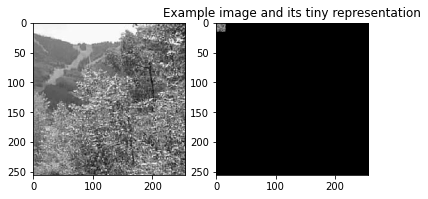

In [18]:
#Step 1: Represent each image with a feature
print('Using Tiny images representation for images') 

train_image = tiny_images(train_image_paths)
test_image  = tiny_images(test_image_paths)


## Entrenar Clasificadores


Pasos:
1. ***Implementar Clasificador:***
Una vez extraída la representación de las imágenes (`tiny_images`) es necesario implementar un clasificador KNN en la funcion nearest_neighbour esta función tiene como parámetros un array N × D de imágenes de entrenamiento (`train_images`), una lista de N elementos conteniendo las etiquetas de entrenamiento (`train_labels`) y un array de M×D conteniendo las imágenes a clasificar (`test_images`). La salida debe ser una lista (`predicted_labels`) de tamaño M conteniendo las predicciones de etiquetas para las imágenes de testing.
2. ***Evaluar Algoritmo:***
Una vez hechas las predicciones la función `create_results_webpage` evalua el algoritmo al comparar las predicciones contra las etiquetas reales de las imágenes de testing (esto se denomina ground truth). En esta evaluación vamos a reportar el ***Accuracy*** total del algoritmo y la matriz de confusión entre clases. También se van a mostrar algunas predicciones de ejemplo que realiza el algoritmo. 



### Matriz de confusión

Una matriz de confusión muestra las distintas clases y el porcentaje de errores de clasificación de cada clase con cada una de las otras clases posibles. Un ejemplo de la salida se puede visualizar en la siguiente figura, donde se ve que para el caso de escenas de una autopista (Highway) clasifica correctamente en el 68 % de los casos.

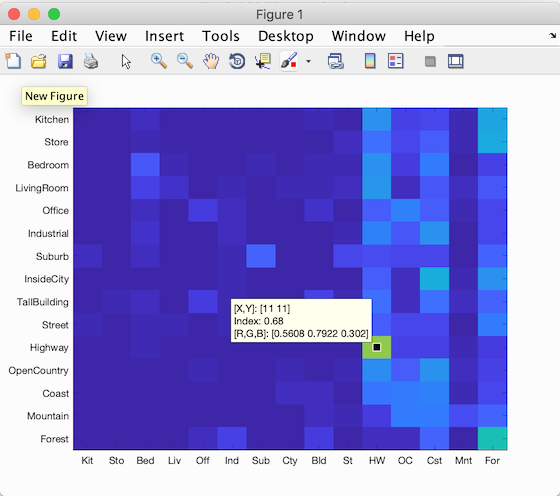


***Como interpretar los resultados***: Para el caso de NN sencillo (1-NN) el accuracy final de la clasificación es 16%. Si bien no es un buen resultado es bastante mejor que utilizar un clasificador random donde el accuracy debería ser 1/15 = 6,6 %

***Hint 1***: Se puede utilizar la función de [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) de Scipy que hace la mayoría del trabajo al implementar el algoritmo de KNN. Otras funciones útiles son min(), [argsort](https://www.kite.com/python/docs/numpy.argsort), unique(). Implementar primero 1-NN y luego extenderlo a KNN.

Una vez implementado el algoritmo se pueden utilizar más datos de entrenamiento para mejorar el Accuracy modificando la variable `num_train_per_cat`
. 

**[Opcional]** 
Probar si los resultados finales varían al hacer alguna de las siguientes mejoras:
1. Modificar el tamaño del thumbnail utilizado para representar una imagen. 
2. Estandarizar los datos antes de clasificar (función [normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html#sklearn.preprocessing.normalize)). 
3. Utilizar otras distancias que no sean la Euclidiana para comparar la representación dos imágenes.

In [19]:
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from scipy.stats import mode

In [ ]:
def nearest_neighbor(train_image, train_labels, test_image,k):

    printf('\n nearest neighbor classifier\n')

    le = preprocessing.LabelEncoder()
    le.fit(train_labels)
    categories = list(le.classes_)
    num_categories = len(categories) 

    test_labels = []
    
    return test_labels

In [20]:
def nearest_neighbor(train_image, train_labels, test_image,k):

    print('Nearest Neighbor classifier')

    le = preprocessing.LabelEncoder()
    le.fit(train_labels)
    categories = list(le.classes_)
    num_categories = len(categories) 

    D = cdist(test_image, train_image)
    index = np.argsort(D,axis=1)
    index = index[:,:k]
    train_labels_array = np.asarray(train_labels)
    klabel=train_labels_array[index]
    klabel_cat = le.transform(klabel.flatten())
    klabel_cat = klabel_cat.reshape(-1,k)
    pred_labels = mode(klabel_cat, axis=1)
    pred_labels = pred_labels.mode
    test_labels = le.inverse_transform(pred_labels)
    
    return test_labels

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_results(train_image_paths,test_image_paths,train_labels,test_labels,categories,abbr_categories,predicted_labels):
    
    fig, ax = plt.subplots(1,1,figsize=(16,16))
    cm = confusion_matrix(test_labels, pred_labels_names, labels=categories, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=categories)
    disp.plot(ax=ax, xticks_rotation=45.)
    disp.ax_.get_images()[0].set_clim(0, 1)
    plt.show()

    accuracy = accuracy_score(test_labels, pred_labels_names)

    print('Overall Accuracy: {:.2f}%'.format(accuracy*100))


In [22]:
#Step 2: Classify each test image by training and using the appropriate classifier
print('Using Nearest Neighbor classifier to predict test set categories')
k=1  # the K nearest neighbor
predicted_labels = nearest_neighbor(train_image, train_labels, test_image,k)  

Using Nearest Neighbor classifier to predict test set categories
Nearest Neighbor classifier


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
from web_page import create_results_webpage

Creating results_webpage/index.html, thumbnails


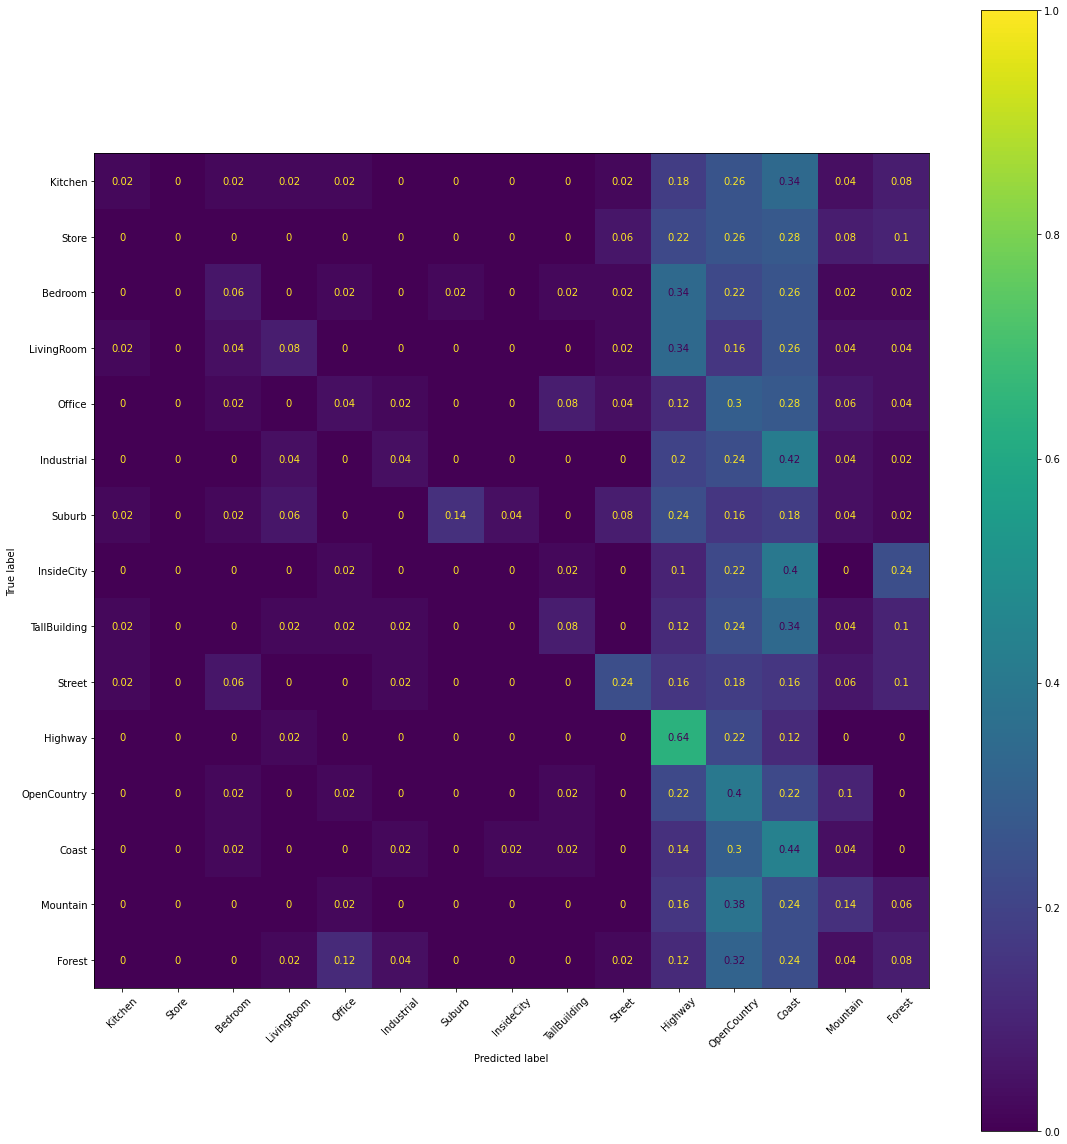

In [24]:
html = create_results_webpage(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, predicted_labels)

In [25]:
import IPython
from google.colab import output

display(IPython.display.HTML(html))

#Parte 2: SIFT BOW con clasificador SVM

La segunda parte consiste en implementar una versión simple del algoritmo que utiliza BOW basado en descriptores SIFT para entrenar un clasificador SVM y clasificar imágenes. Para ello se probee el siguiente esqueleto de còdigo. 
Es necesario implmentar las funciones `codebook` que crea el vocabulario visual y la función `bag_of_words` que extrae la representación de una imagen con el algoritmo "*bag_of_features*" visto en clase.

## Construir el CodeBook
En la función codebook se pide armar le vocabulario visual realizando los siguientes pasos:
1. Iterar sobre los image path de las imágenes de entrada para cargar cada imagen y llamar una función que extraiga puntos SIFT con sus descriptores. Vamos a utilizar la implementación de SIFT para python de vl_feat en la cual se pueden obtener keypoints y descriptores utilizandos las funciones `sift` y `dsift`(dense sift). (*hint:* es recomendable hacer blur antes de calcular descriptores sift.)
2. Agrupar todos los descriptores en una matriz y armar clusters de datos con una rutina k-means se puede utilizar la implementación de scikit-learn de [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Finalmente utilizar el parámetro `num_words` para cambiar el numero de palabras en el diccionario visual.

\**Hint 1: Para hacer debbuging mientras se implementa el algoritmo se pueden utilizar menos imágenes de entrenamiento y menos palabras en el diccionario. Una vez implementado correctamente el algoritmo se pueden modificar estos parámetros para utilizar más datos y más palabras en el diccionario. El algoritmo puede demorar algunos minutos en entrenarse.*

\**Hint 2: Para acelerar el proceso de evaluar el algoritmo k-means es posible utilizar el algoritmo [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) provisto por scikit-learn*



In [31]:
from cyvlfeat.sift import sift, dsift
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [ ]:
def codebook(image_paths,num_of_words):
  print('building visual vocabulary')

  

  print('finish building vocaulary')


In [26]:

def codebook(image_paths,num_of_words):
  print('Extracting image features')
  num_images = len(image_paths)
  container = []
  
  for image_fn in tqdm(image_paths,total=num_images):
      img = cv2.imread(image_fn,0)
      img = cv2.GaussianBlur(img, (3,3), 0.5)
      sift_keypoints, sift_descriptors = dsift(img,step=30,size=20, fast=True)
      container += (list(sift_descriptors))

  container = np.asarray(container)
  print(container.shape)
  print('start to building vocaulary')
  kmeans = MiniBatchKMeans(n_clusters=num_of_words).fit(container)
  dictionary = kmeans.cluster_centers_
  print('finish building vocaulary')

  return dictionary



In [27]:
if not os.path.exists('vocab.npy'):
  print('No existing visual word vocabulary found. Computing one from training images')

  num_of_words = 800; #Larger values will work better (to a point) but be slower to compute

  vocab = codebook(train_image_paths, num_of_words)
  np.save('vocab', vocab)

In [28]:
vocab = np.load('vocab.npy')

## Utilizar el diccionario visual para representar una imagen como Bag of Words


En la función `bag_of_words` se deben leer las imágenes nuevamente y codificarlas utilizando el *codebook* o vocabulario visual entrenado previamente. Para hacer esto se puede seguir el siguiente procedimiento:

1. Extraer features para cada imagen utilizando el mismo extractor de features que en el codebook(ej. `dsift` extrae keypoints y los representa con descriptor de 128 bytes).
2.  Proyectar los descriptores a las palabras del diccionario visual (Se puede utilizar las funcion [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) más la función min para hacer esto).
3. Codificar las imágenes en un histograma de palabras visuales (Se puede utilizar la funcion [histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) de numpy). Es recomendable normalizar el histograma.


Una vez hecho esto, la función `bag_of_words` debe retornar una matriz de tamaño *N × num_of_words* conteniendo el histograma BoW para cada una de las N imágenes.

In [ ]:
def bag_of_words(image_paths,codebook):

  word_lenght = codebook.shape[1]
  vocab_size = codebook.shape[0]
  print('bags of words')
  num_images = len(image_paths)
  container = []
  image_features = np.zeros([num_images,vocab_size])

  ### YOUR CODE 

  return image_features

In [32]:
def bag_of_words(image_paths,codebook):

  word_lenght = codebook.shape[1]
  vocab_size = codebook.shape[0]

  print('bags of words')
  num_images = len(image_paths)
  container = []
  image_features = np.zeros([num_images,vocab_size])
  for idx, image_fn in tqdm(enumerate(image_paths),total=num_images):
      img = cv2.imread(image_fn,0)
      img = cv2.GaussianBlur(img, (3,3), 0.5)

      sift_keypoints, sift_descriptors = dsift(img,step=30,size=20, fast=True)

      dist = cdist(sift_descriptors,codebook)
      index=np.argmin(dist, axis=1)

      hist_values, hist_edges = np.histogram(index,np.arange(0,vocab_size+1,1), density=True)
      image_features[idx,:] = hist_values

  return image_features

In [33]:
train_image_features = bag_of_words(train_image_paths,vocab)
test_image_features  = bag_of_words(test_image_paths,vocab)

  1%|          | 6/750 [00:00<00:13, 55.73it/s]

bags of words


  1%|          | 6/750 [00:00<00:12, 57.56it/s]

bags of words


100%|██████████| 750/750 [00:13<00:00, 54.74it/s]


## Clasificar utilizando un SVM


El código para entrenar el clasificador SVM ya está implementado aunque los estudiantes pueden modificarlo si desean. El código utiliza la función vl_ svmtrain para entrenar y testear el clasificador SVM dependiendo de los para ́metros que se le pasen. El siguiente co ́digo sirve para evaluar las im ́agenes de test:

In [36]:
from sklearn.svm import LinearSVC


In [37]:
def svm(train_image, train_labels, test_image):

  C_factor = 0.001
  clf = LinearSVC(C=C_factor, multi_class='ovr')
  print('svm training started ')

  clf.fit(train_image, train_labels)
  print('svm training finished ')

  predictions = clf.predict(test_image)

  return predictions


In [42]:
predicted_labels = svm(train_image_features,train_labels,test_image_features)

svm training started 
svm training finished 


Creating results_webpage/index.html, thumbnails


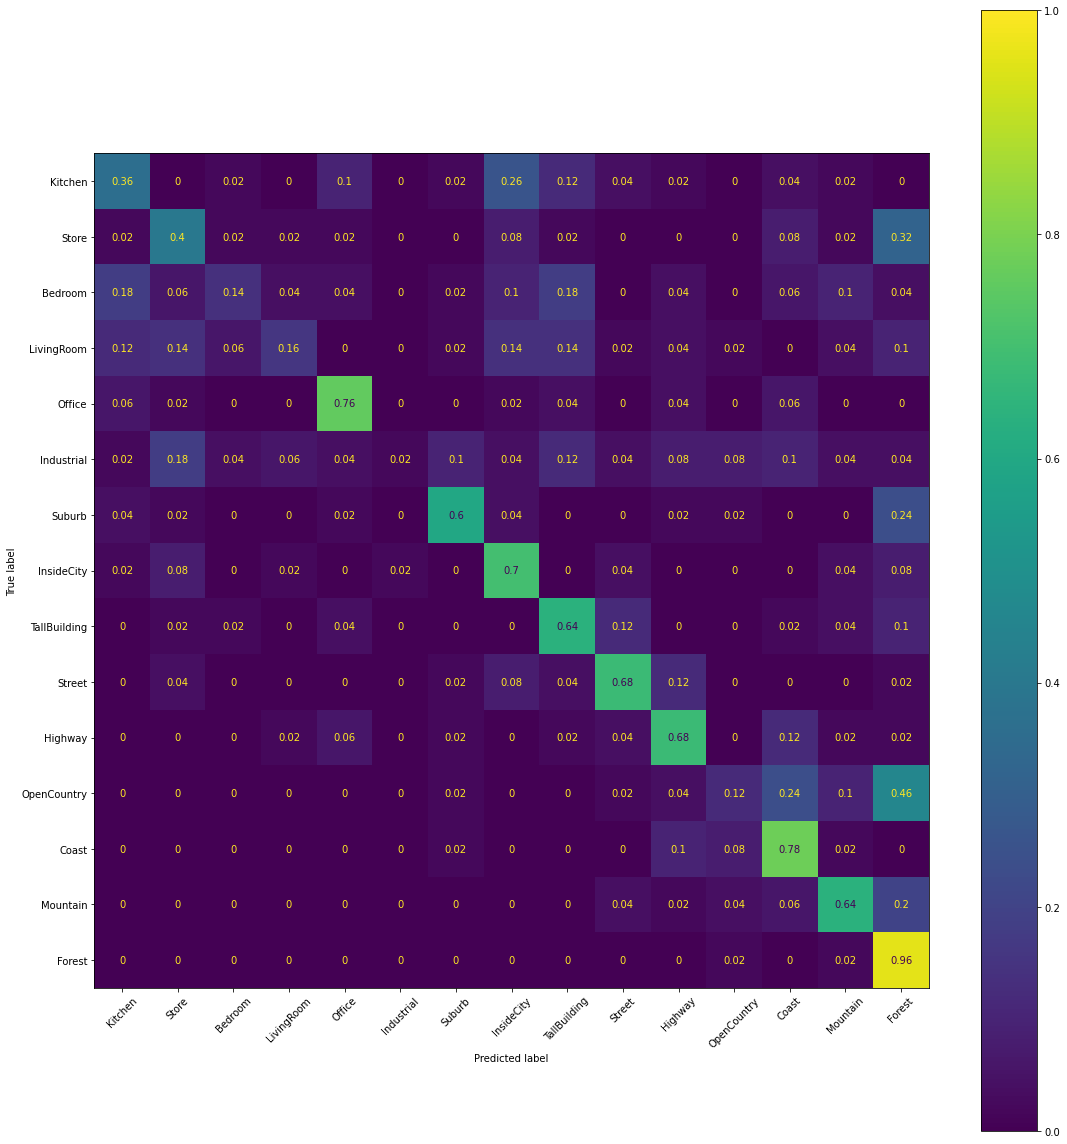

In [43]:
html = create_results_webpage(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories, predicted_labels)

In [44]:
import IPython

display(IPython.display.HTML(html))

##  Resultados Finales


El código para entrenar el clasificador SVM ya está implementado aunque los estudiantes pueden modificarlo si desean. El código utiliza el modelo [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) de scikit-learn para entrenar y testear el clasificador SVM. 

Como el clasificador SVM es lineal en este caso se entrenan 15 1-vs-rest clasificadores (esto se hace automáticamente al pasarle al clasificador el parametrod `multi_class='ovr'`). El SVM utiliza un parámetro de regularización C, se puede seleccionar el valor manualmente o utilizando un algoritmos del tipo grid-search para buscar un valor más óptimo.

**Resultados Esperados**: En este caso una implementación simple de SIFT BoW + SVM utilizando `dsift` debe estar cerca de 22% de Accuracy.

**[Opcional]** En el [articulo original](https://inc.ucsd.edu/~marni/Igert/Lazebnik_06.pdf) presentado en 2006 los autores reportan alrededor de un 70% de Accuracy. Para ello es necesario afinar todas las partes del pipeline del algoritmo. Optimizar la extracción de features SIFT, optimizar el vocabulario visual y optimizar la regularización del SVM. Buscar en el árticulo original los parámetros necesarios para llegar al nivel de Accuracy señalado.
